In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#         pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# IMPORTS

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from PIL import Image
import h5py
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel,pipeline
import re
from nltk.corpus import stopwords

In [ ]:
BATCH_SIZE=1 #16
LR=0.0002
BETAS=(0.5,0.999)
NUM_EPOCHS=10
z_dim=200

# Text Preprocessing

In [4]:
def preprocessing(label):
    
    stop_words = set(stopwords.words('english'))
    cleaned_string = re.sub(r'\d+', '', label) 
    cleaned_string = re.sub(r'[^\w\s]', '', cleaned_string).lower()  
    cleaned_string = cleaned_string.replace('_', ' ')  
   
    words = cleaned_string.split()  
    cleaned_string = " ".join([word for word in words if word not in stop_words]) 
    return cleaned_string

In [5]:
# Initialize the BERT pipeline for feature extraction
embedder = pipeline('feature-extraction', model='bert-base-uncased', tokenizer='bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:
# Define a function to get BERT embeddings
def get_bert_embedding(caption):
    embedding = embedder(caption)
    mean_embedding = np.mean(embedding[0], axis=0)
    return mean_embedding

In [ ]:
# !pip install torchfile
# import os
# import torchfile

# # Path to the folder containing the .t7 files
# t7_folder_path = '/kaggle/input/cub2002011/cvpr2016_cub/w2v_c10'

# # List all .t7 files in the folder
# t7_files = [f for f in os.listdir(t7_folder_path) if f.endswith('.t7')]

# # Loop through each .t7 file and load it
# for t7_file in t7_files:
#     t7_file_path = os.path.join(t7_folder_path, t7_file)
    
#     # Load the .t7 file
#     t7_data = torchfile.load(t7_file_path)
    
#     # Print the name of the file and the data
#     print(f"File: {t7_file}")
#     print("Data:", t7_data)

# print(t7_data.shape)
# print(t7_data[1][0])

# Dataset Class

In [8]:
class CUBTextImageDataset(Dataset):
    def __init__(self, image_dir, text_dir, transform=None):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform
        self.image_folders = sorted(os.listdir(image_dir))

    def __len__(self):
        return sum([len(os.listdir(os.path.join(self.image_dir, folder))) for folder in self.image_folders])

    def __getitem__(self, idx):
        folder_idx = 0
        while idx >= len(os.listdir(os.path.join(self.image_dir, self.image_folders[folder_idx]))):
            idx -= len(os.listdir(os.path.join(self.image_dir, self.image_folders[folder_idx])))
            folder_idx += 1
        
        image_folder = self.image_folders[folder_idx]
        image_file = sorted(os.listdir(os.path.join(self.image_dir, image_folder)))[idx]
        image_path = os.path.join(self.image_dir, image_folder, image_file)

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        base_name = os.path.splitext(image_file)[0]
        txt_path = os.path.join(self.text_dir, image_folder, base_name + ".txt")
        with open(txt_path, 'r') as file:
            txt_description = file.read().strip()
        return image, txt_description


In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
image_dir = '/kaggle/input/cub2002011/CUB_200_2011/images'
text_dir = '/kaggle/input/cub2002011/cvpr2016_cub/text_c10'

In [11]:
dataset = CUBTextImageDataset(image_dir=image_dir, text_dir=text_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
dataset

In [18]:
descriptions[0].split('\n')[0]

'yellow crown and breast and flank. gray wings and brown on top.'

In [12]:
# Check a few samples from the DataLoader
for images, descriptions in dataloader:
    for i in range(10):
        print("Batch of Images:", images.shape)
        print("Text:",i, descriptions[0].split('\n')[i])
    break

Batch of Images: torch.Size([1, 3, 128, 128])
Text:  0 a small bird, mostly yellow, with black and white wings and a black beak.
Batch of Images: torch.Size([1, 3, 128, 128])
Text:  1 a small bird with a chartreuse large head and regular belly, with dark grey wings and white wing bars, and a slightly rounded bottom bill.
Batch of Images: torch.Size([1, 3, 128, 128])
Text:  2 a small colorful bird with a yellow eye ring, green covering its head, nape, throat, breast and side, grey on its belly and vent, and black wings with two white wing bars.
Batch of Images: torch.Size([1, 3, 128, 128])
Text:  3 the bird has a yellow body and black wings with white wingbars.
Batch of Images: torch.Size([1, 3, 128, 128])
Text:  4 this bird is green with white on its stomach and has a very short beak.
Batch of Images: torch.Size([1, 3, 128, 128])
Text:  5 this bird has feathers that are black and has a yellow body
Batch of Images: torch.Size([1, 3, 128, 128])
Text:  6 this bird is yellow with black win

In [34]:
def get_noise(BATCH_SIZE, z_dim, device='cpu'):
    return torch.randn(BATCH_SIZE, z_dim,1,1).to(device) 

In [48]:
dat=Text2ImageDataset('/kaggle/input/cub2002011')

In [40]:
def visualize_images(path):
    image_filenames = os.listdir(path)
    num_images = min(10, len(image_filenames))
    num_rows = num_images // 5 + (1 if num_images % 5 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        axes[i].imshow(image, cmap='gray')
#         axes[i].set_title(image_filename, fontsize=8)

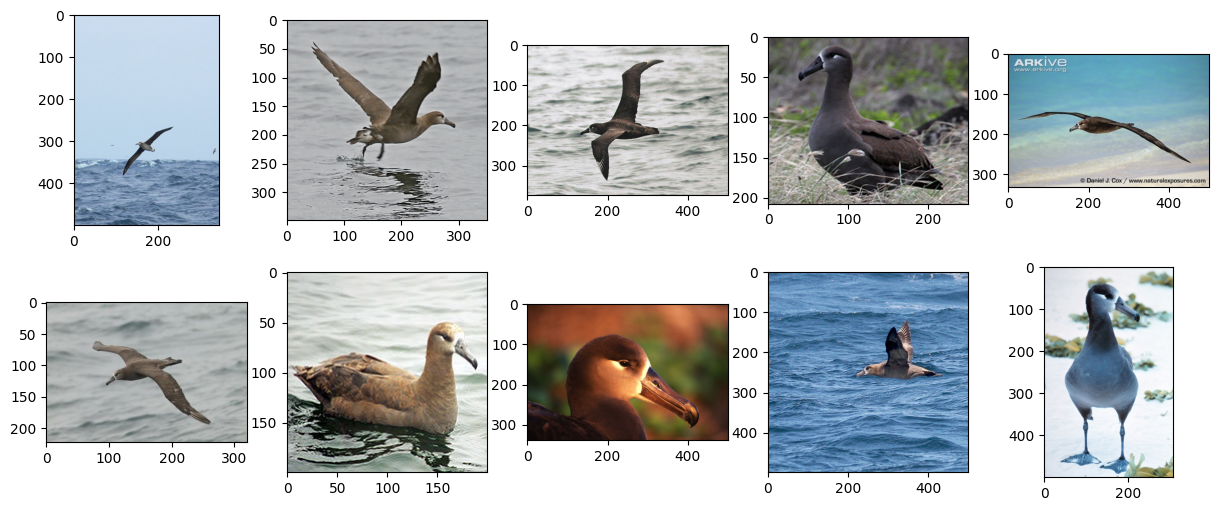

In [41]:
Black_footed_Albatross_dir='/kaggle/input/cub2002011/CUB_200_2011/images/001.Black_footed_Albatross'
visualize_images(Black_footed_Albatross_dir)

# Architecture

## Generator

In [15]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,Gen=True,drop=False,norm=True,act='relu',kernel_size=3,stride=1,padding=1):
        super(ConvBlock,self).__init__()
        self.drop=drop
        self.norm=norm
        self.Gen=Gen
        self.dropout = nn.Dropout2d(0.5)
        self.act = act
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding) if Gen else nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels) if norm else nn.Identity(),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        if self.drop:
            x = self.dropout(x)
        return self.block(x)

In [16]:
class Generator(nn.Module):
    def __init__(self,embed_dim=768,z_dim=100,num_channels=3,hidden_dim=32):
        super(Generator, self).__init__()
        self.linear=nn.Sequential(
            nn.Linear(embed_dim,128),
#             nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv1 = ConvBlock(z_dim+embed_dim,hidden_dim*16,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv2 = ConvBlock(hidden_dim*16,hidden_dim*8,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv3 = ConvBlock(hidden_dim*8,hidden_dim*4,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv4 = ConvBlock(hidden_dim*4,hidden_dim*2,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv5 = ConvBlock(hidden_dim*2,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv6 = ConvBlock(hidden_dim,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv7 = ConvBlock(hidden_dim,num_channels,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.tanh=nn.Tanh()
#         self.embedding=nn.Embedding(200,128)
    
    def forward(self,x,label):
        print(label.shape)# torch.Size([BATCH_SIZE,768])
        label=label.unsqueeze(2).unsqueeze(3)
        print(label.shape)# torch.Size([BATCH_SIZE,768,1,1])
        z=torch.cat([label,x],dim=1)
        print(z.shape)#     torch.Size([BATCH_SIZE, 868, 1, 1])
        x = self.conv1(z)
        print(x.shape) #    torch.Size([BATCH_SIZE, 512, 2, 2])
        x = self.conv2(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 256, 4, 4])
        x = self.conv3(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 128, 8, 8])
        x = self.conv4(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 64, 16, 16])
        x = self.conv5(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 32, 32, 32])
        x = self.conv6(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 32, 64, 64])
        x = self.conv7(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 3, 128, 128])
        return self.tanh(x)

### Testing Gen

In [17]:
gen=Generator()

In [18]:
embed=torch.rand(1,768)
img=torch.rand(1,100,1,1)
gen(img,embed).shape

torch.Size([1, 768])
torch.Size([1, 768, 1, 1])
torch.Size([1, 868, 1, 1])
torch.Size([1, 512, 2, 2])
torch.Size([1, 256, 4, 4])
torch.Size([1, 128, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 64, 64])
torch.Size([1, 3, 128, 128])


torch.Size([1, 3, 128, 128])

## Discriminator

In [55]:
class Concat_embed(nn.Module):
    def __init__(self, embed_dim=768, projected_embed_dim=128):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=768, out_features=128),
            nn.Identity(),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        print(replicated_embed.shape)
        print(inp.shape)

        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat


In [59]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.image_size = 128
        self.num_channels = 3
        self.embed_dim = 768
        self.projected_embed_dim = 128
        self.ndf = 64
        self.B_dim = 128
        self.C_dim = 16

        self.netD_1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 8, self.ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)

        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 16 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            )

    def forward(self, inp, embed):
        x_intermediate = self.netD_1(inp)
        x = self.projector(x_intermediate, embed)
        x = self.netD_2(x)

        return x.view(-1, 1).squeeze(1) , x_intermediate

### Testing Disc

In [60]:
disc=Discriminator()

In [61]:
embed=torch.rand(1,768)
img=torch.rand(1,3,128,128)
disc(img,embed)

torch.Size([1, 128, 4, 4])
torch.Size([1, 1024, 4, 4])


(tensor([0.3894], grad_fn=<SqueezeBackward1>),
 tensor([[[[-0.2029, -0.0453,  0.5699,  0.5334],
           [-0.1703, -0.0262, -0.3794,  0.0840],
           [ 0.2018,  0.8458,  0.3536, -0.1938],
           [ 0.0891,  2.1211,  1.4855, -0.2389]],
 
          [[ 0.0846, -0.2269, -0.2389, -0.2426],
           [-0.3588,  0.3023,  0.9511,  0.3719],
           [ 0.7489,  0.5422, -0.2067, -0.1852],
           [ 1.0810,  1.1686,  1.1760,  0.8693]],
 
          [[ 0.2687,  1.5105,  1.1501,  0.4146],
           [-0.2039, -0.4673, -0.1236, -0.0117],
           [ 1.0063, -0.0206, -0.3242,  0.5383],
           [ 0.1209, -0.0273, -0.0460,  1.1138]],
 
          ...,
 
          [[-0.1027, -0.3487, -0.1424,  0.1068],
           [ 0.4887, -0.1109,  0.4524, -0.1080],
           [ 0.1537, -0.1472,  0.4280, -0.0605],
           [ 0.0828,  2.6357,  1.6128, -0.1718]],
 
          [[ 0.8932, -0.0365, -0.0131,  1.2999],
           [-0.0578,  0.2189,  1.1864, -0.0618],
           [-0.0546, -0.3039,  0.8790, -0.

# Text Embedding

In [29]:
# Check a few samples from the DataLoader
for images, descriptions in dataloader:
    for i in range(10):
        print("Batch of Images:", images.shape)
        print("Batch of Text Descriptions: ", descriptions[0].split('\n')[i])
    break

Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird has a very noticeable black crown, nape and cheek patch while its eyebrow is starkwhite, it has a short, black beak and mottled yellow wings.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird is brown with a white chest and has a very short beak.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this small bird has a black head with a white eyepatch and white throat.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this is a small, white bird with a black crown and brown wingbars.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this small white bird has a black head and yellow and black wings.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  the small bird has a black crown with a white belly
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions: 

In [14]:
text=descriptions[0].split('\n')[0]

In [17]:
test_df=pd.DataFrame(descriptions[0].split('\n'))

In [20]:
# # Assign the embeddings to a new column in the sampled dataframe
test_df['vector'] = test_df[0].apply(lambda x: get_bert_embedding(x))
test_df.head()

,0,vector
0,"a white bird with webbed feet, an orange beak ...","[-0.014718351065225545, -0.05030688155619871, ..."
1,"a large bird with an expansive wing span, that...","[-0.1399901636847944, 0.04223645486953584, -0...."
2,"this bird has a wide wingspan, a long orange b...","[-0.04294362664222717, 0.2631648364274398, -0...."
3,"this bird has a bright orange bill, a light gr...","[-0.0761377125684368, 0.17957989935223995, -0...."
4,this seagull has white feathers and a small or...,"[-0.25227072884639107, 0.11543269527610392, -0..."


In [37]:
test_df['vector'].iloc[0].shape

(768,)

In [35]:
test_df[0].iloc[1].split(' ').__len__()

29